In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import copy
from glob import glob
from tqdm import tqdm

import SimpleITK as stk
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage import measure

In [2]:
root = "../DATA/subset0/"

In [3]:
def load_mhd(file):
    mhdimage = stk.ReadImage(root+file)
    ct_scan = stk.GetArrayFromImage(mhdimage)                 # indexes are z,y,x
    origin = np.array(list(mhdimage.GetOrigin()))   # x,y,z  Origin in world coordinates (mm)
    space = np.array(list(mhdimage.GetSpacing()))   # spacing of voxels in world coor. (mm)
    return ct_scan, origin, space

In [4]:
###### Test CT-Scans #######
test1 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd"
test2 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd"
test3 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd"
test4 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd"
test5 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd"
test6 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd"
test7 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd"
test8 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd"
tests = [test1, test2, test3, test4, test5, test6, test7, test8]
layers = [69, 378, 82, 85, 85, 85, 85, 85]

In [5]:
###### Test ######
for i,test in enumerate(tests):
    exec(f"ct{i+1}, origin{i+1}, space{i+1} = load_mhd(test)")

print("CT_SCAN SHAPE:",ct1.shape)
print("Origin:",origin1)
print("Space:",space1)
print("MAX:",ct1.max())
print("MIN:",ct2.min())

CT_SCAN SHAPE: (161, 512, 512)
Origin: [-187.699997 -108.300003 -194.      ]
Space: [0.54882801 0.54882801 1.25      ]
MAX: 2211
MIN: -3024


In [6]:
def display(imgs, layers=layers.copy(), titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//4 if n%4==0 else (n//4)+1
    plt.figure(figsize=(25,14))
    for i,img in enumerate(imgs):
        plt.subplot(r,4,i+1)
        if len(img.shape) == 3:
            if titles is not None:
                plt.title(titles[i])
            plt.imshow(img[layers[i]], cmap=cmap)
        else:
            if titles is not None:
                plt.title(titles[i])
            plt.imshow(img, cmap=cmap)

In [7]:
test_imgs = [ct1, ct2, ct3, ct4, ct5, ct6, ct7, ct8]

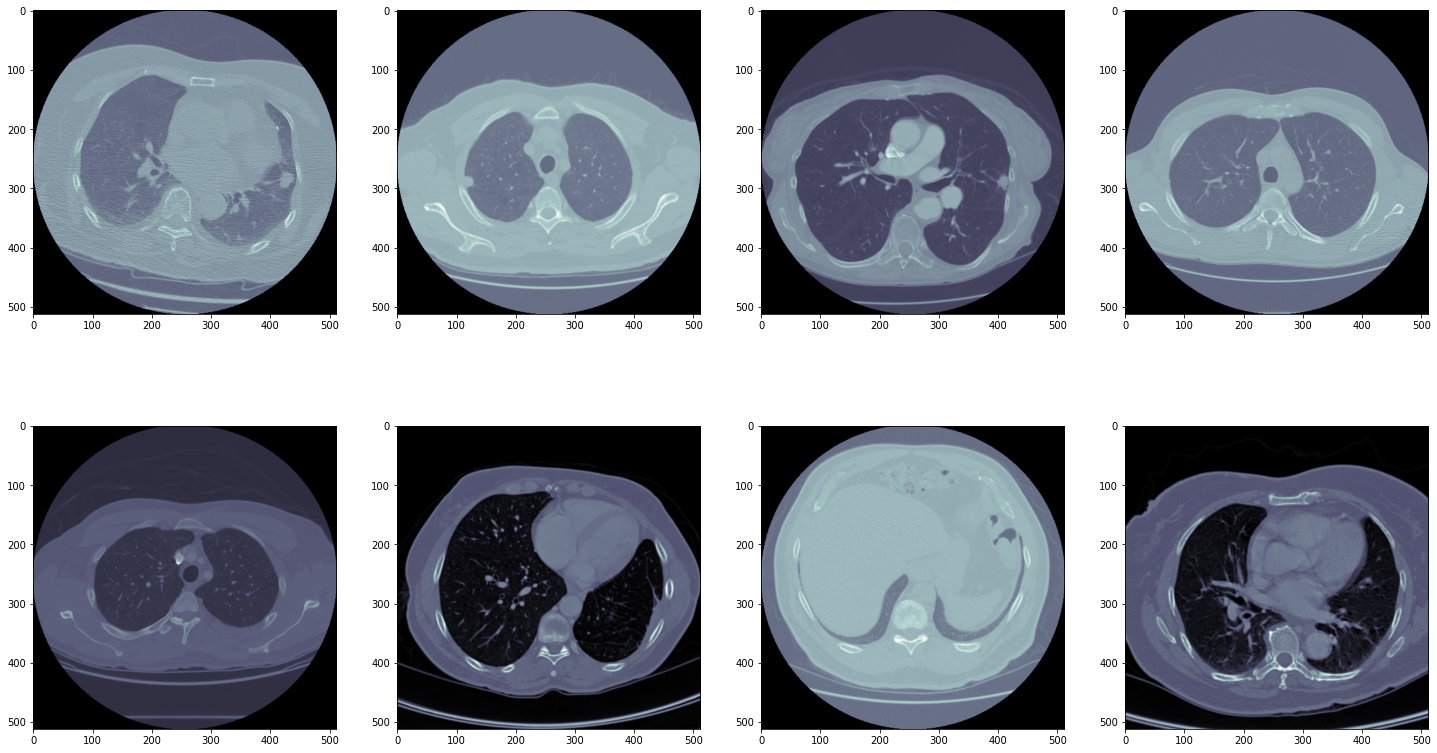

In [8]:
display(test_imgs)

In [9]:
norm_imgs = []
for ct in test_imgs:
    ig = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)
    norm_imgs.append(ig)

print("MAX:",norm_imgs[1].max())
print("MIN:",norm_imgs[1].min())

MAX: 255
MIN: 0


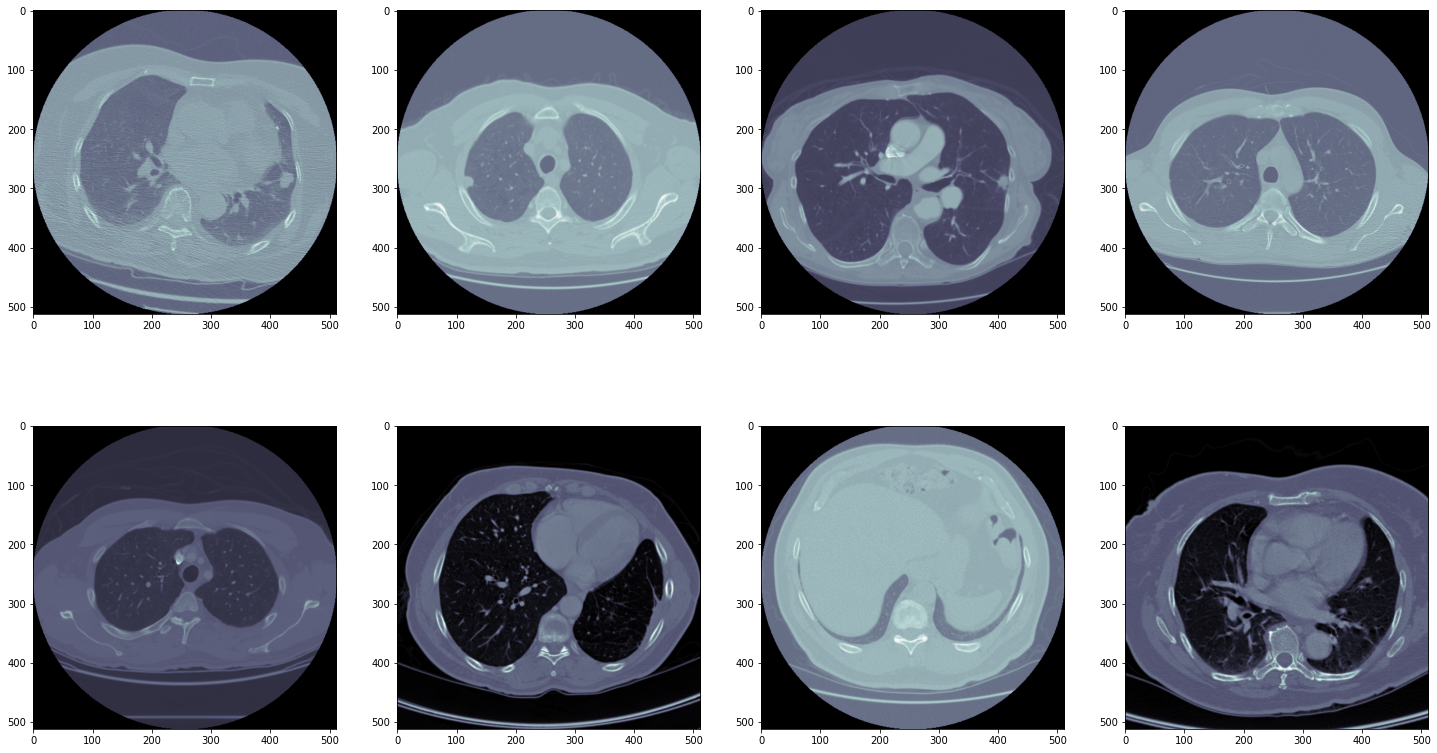

In [10]:
display(norm_imgs)

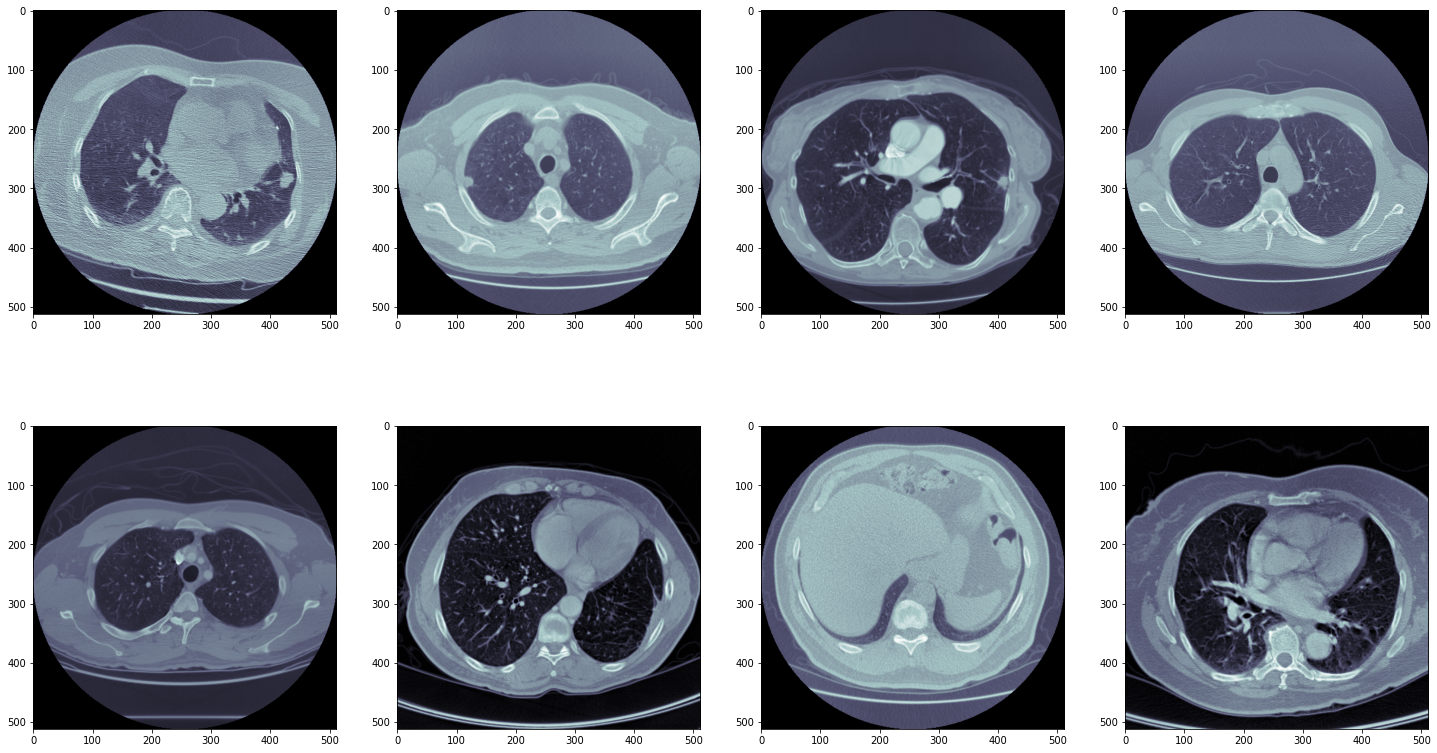

In [11]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
adjusted_norm_imgs = copy.deepcopy(norm_imgs)
for img in adjusted_norm_imgs:
    for i in range(img.shape[0]):
        im = img[i]
        im = clahe.apply(im.astype(np.uint8))
        img[i] = im
display(adjusted_norm_imgs)

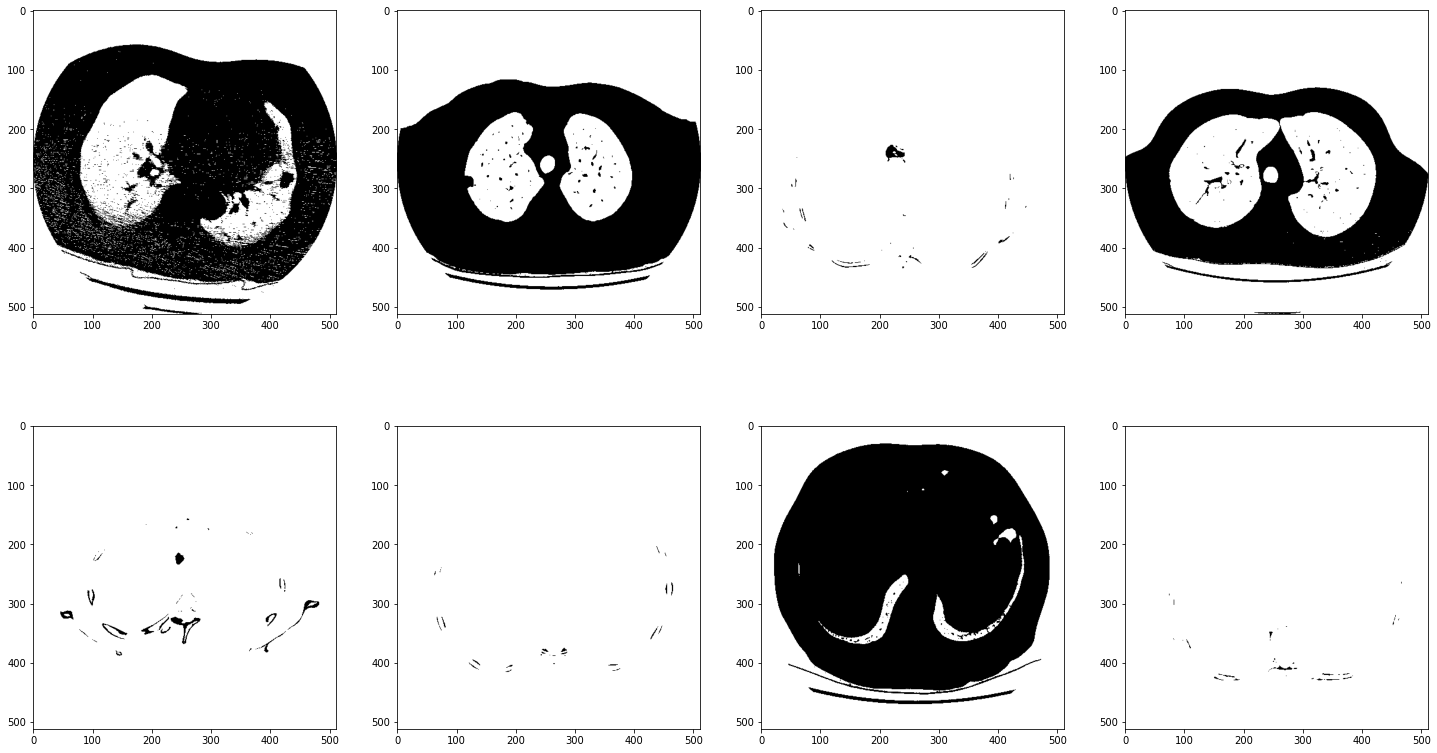

In [12]:
thres = []
for img in norm_imgs:
    ret, t = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    thres.append(t)
display(thres, cmap="gray")

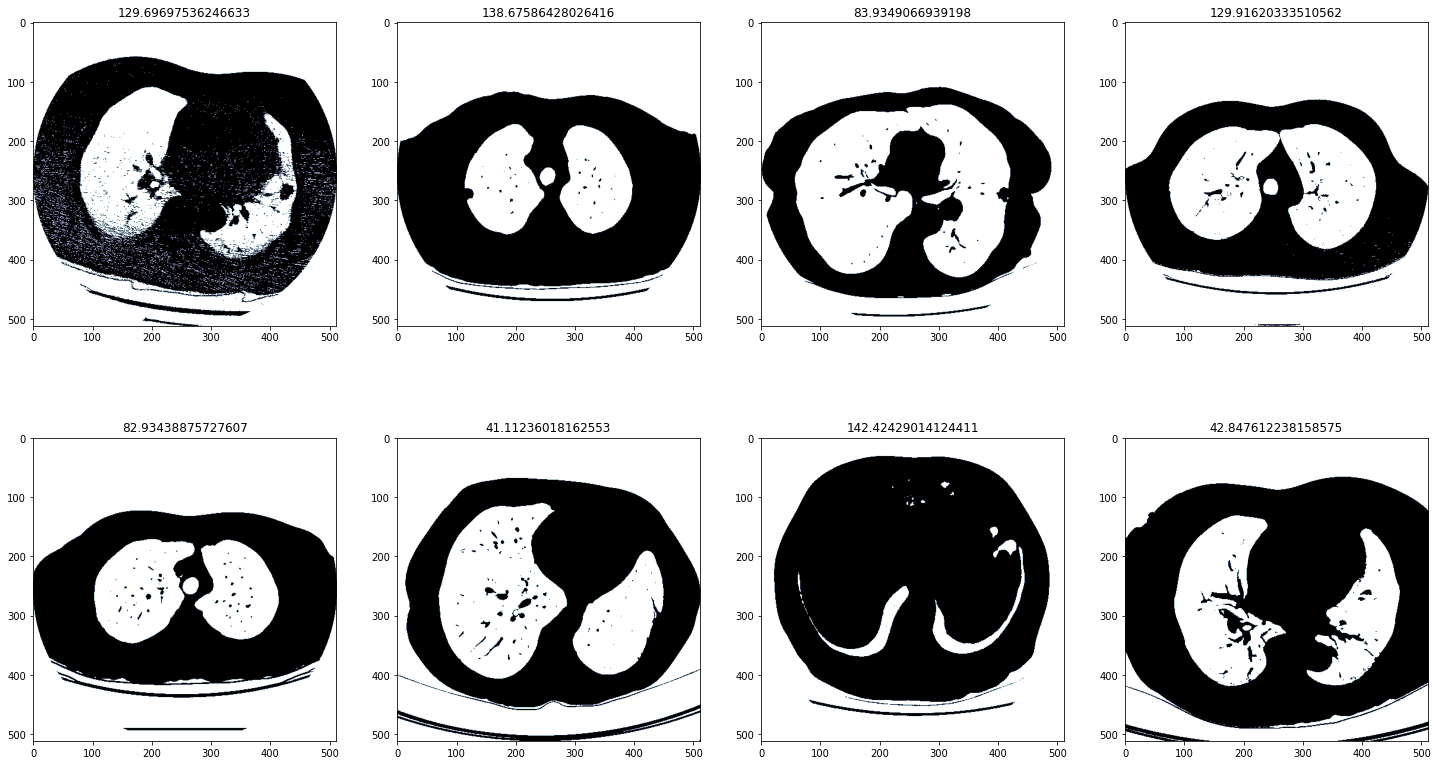

In [13]:
thres2 = []
thres_vals = []
for i,img in enumerate(norm_imgs):
    img = img[layers[i]]
    centeral_area = img[100:400, 100:400]
    kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    ret, thres_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    thres2.append(thres_img)
    thres_vals.append(threshold)

display(thres2, titles=thres_vals)

### Removing noise

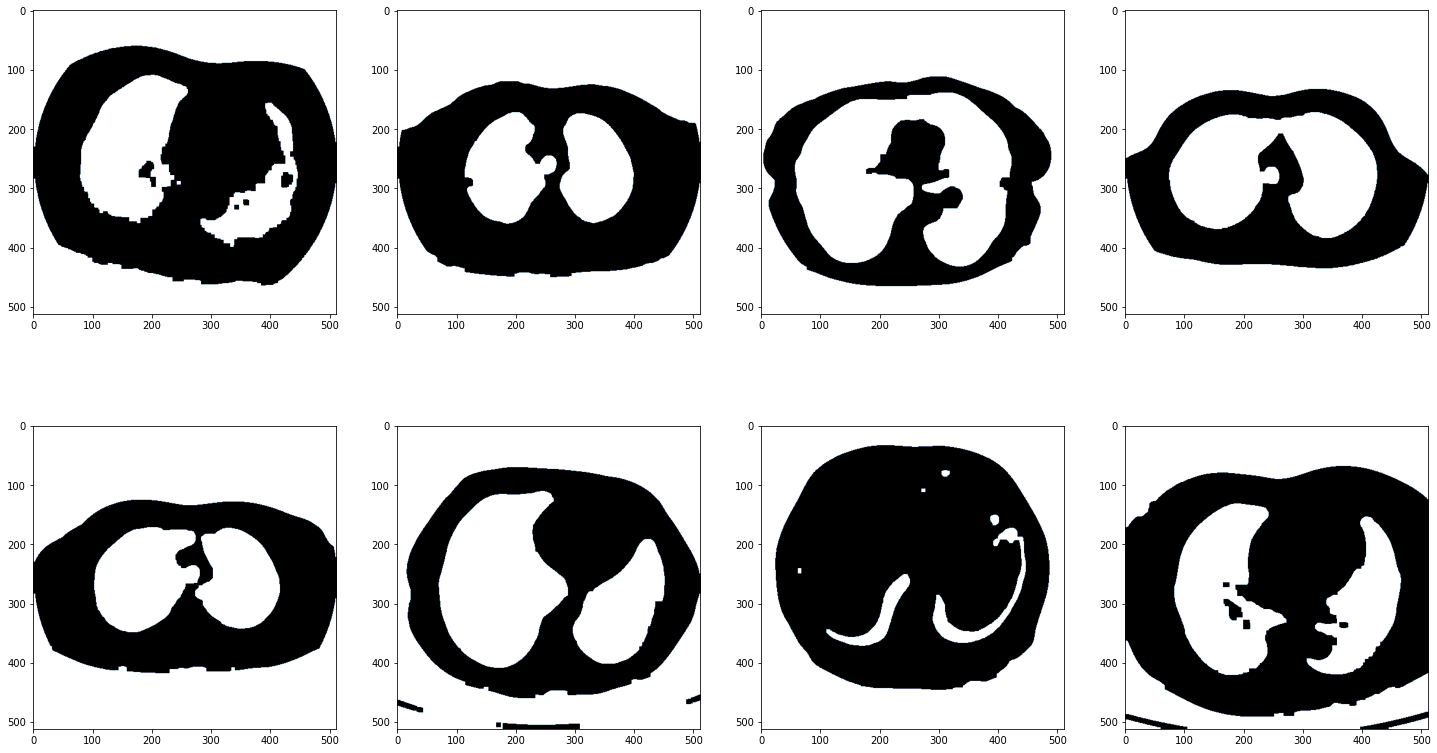

In [14]:
morphed_imgs = []
for img in thres2:
    img = cv2.erode(img, kernel=np.ones([4,4]))
    img = cv2.dilate(img, kernel=np.ones([13,13]))
    img = cv2.erode(img, kernel=np.ones([8,8]))
    morphed_imgs.append(img)
    
display(morphed_imgs)

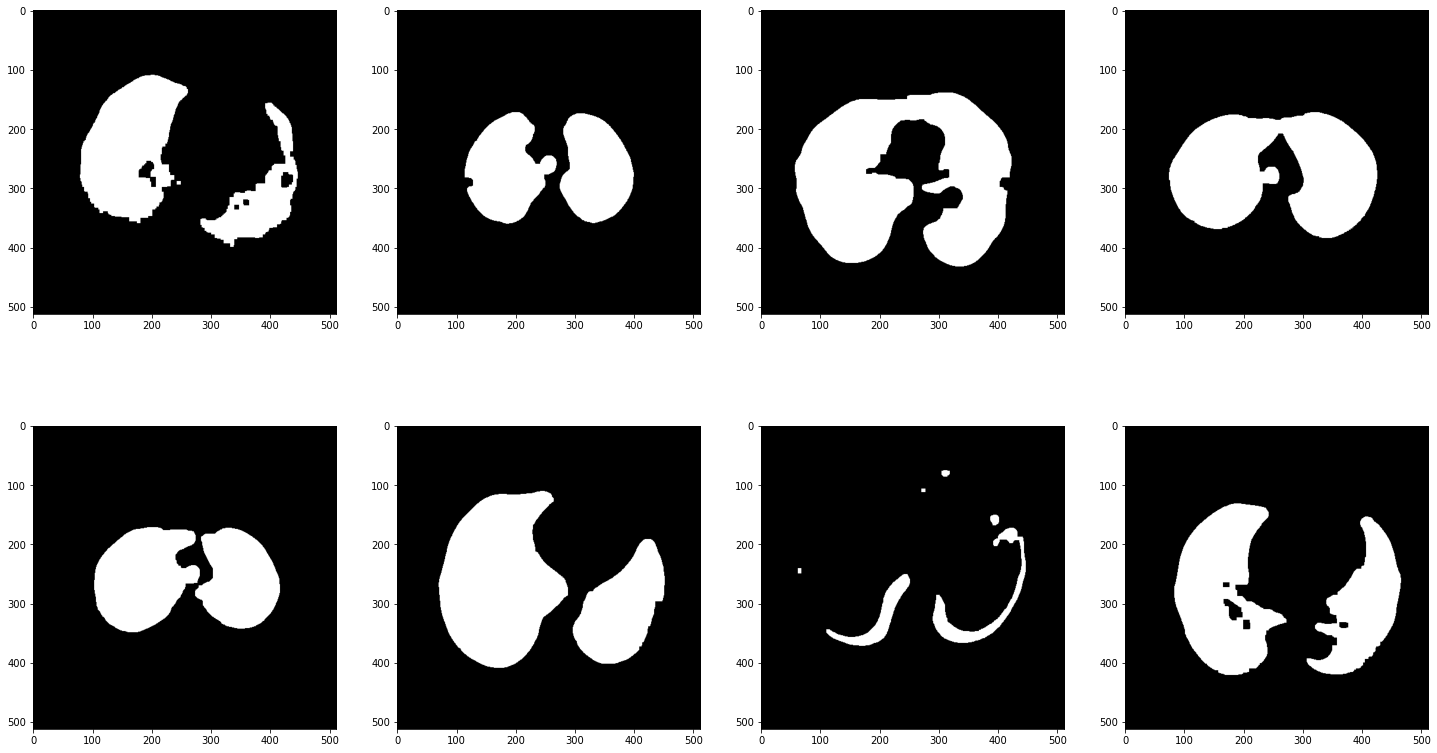

In [15]:
#  Label each region and obtain the region properties
#  The background region is removed by removing regions 
#  with a bbox that is to large in either dimnsion
#  Also, the lungs are generally far away from the top 
#  and bottom of the image, so any regions that are too
#  close to the top and bottom are removed
#  This does not produce a perfect segmentation of the lungs
#  from the image, but it is surprisingly good considering its
#  simplicity. 

processed_masks = []
for img in morphed_imgs:
    labels = measure.label(img)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0] < 500 and B[3]-B[1] < 490 and B[0] > 17 and B[2] < 495:
            good_labels.append(prop.label)

    mask = np.zeros_like(labels)
    for N in good_labels:
        mask = mask + np.where(labels == N, 1, 0)
    processed_masks.append(mask)

display(processed_masks, cmap="gray")

### Filling internal holes

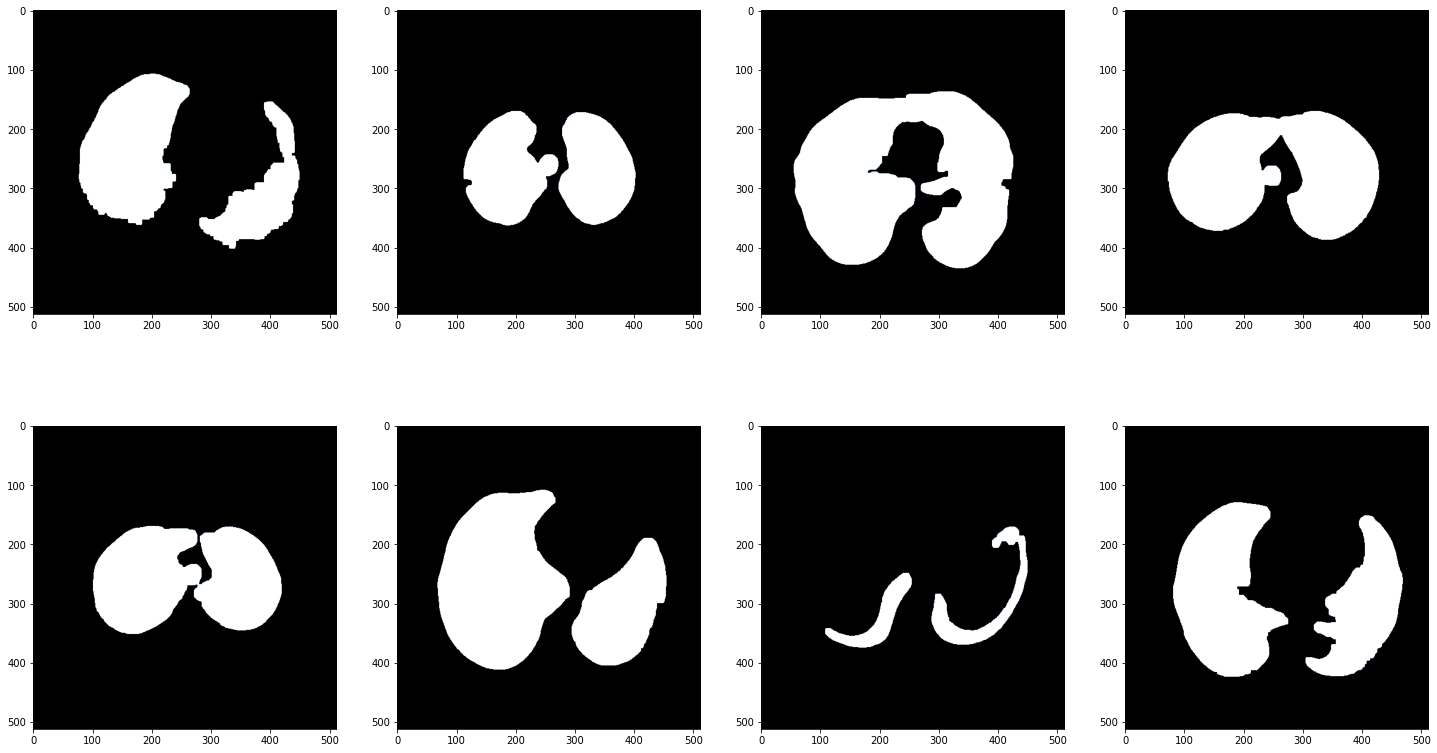

In [16]:
p_final_masks = []
for im_th in processed_masks:
    contours,hirearchy = cv2.findContours(im_th,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    internal_contours = np.zeros(im_th.shape)
    external_contours = np.zeros(im_th.shape)
    for i in range(len(contours)):
        if hirearchy[0][i][3] == -1:  #External Contours
            area = cv2.contourArea(contours[i])
            if area>518.0:
                cv2.drawContours(external_contours,contours,i,(1,1,1),-1)
    external_contours = img = cv2.dilate(external_contours, kernel=np.ones([4,4]))
    p_final_masks.append(external_contours)
display(p_final_masks)

### Seperating nodules attached to walls

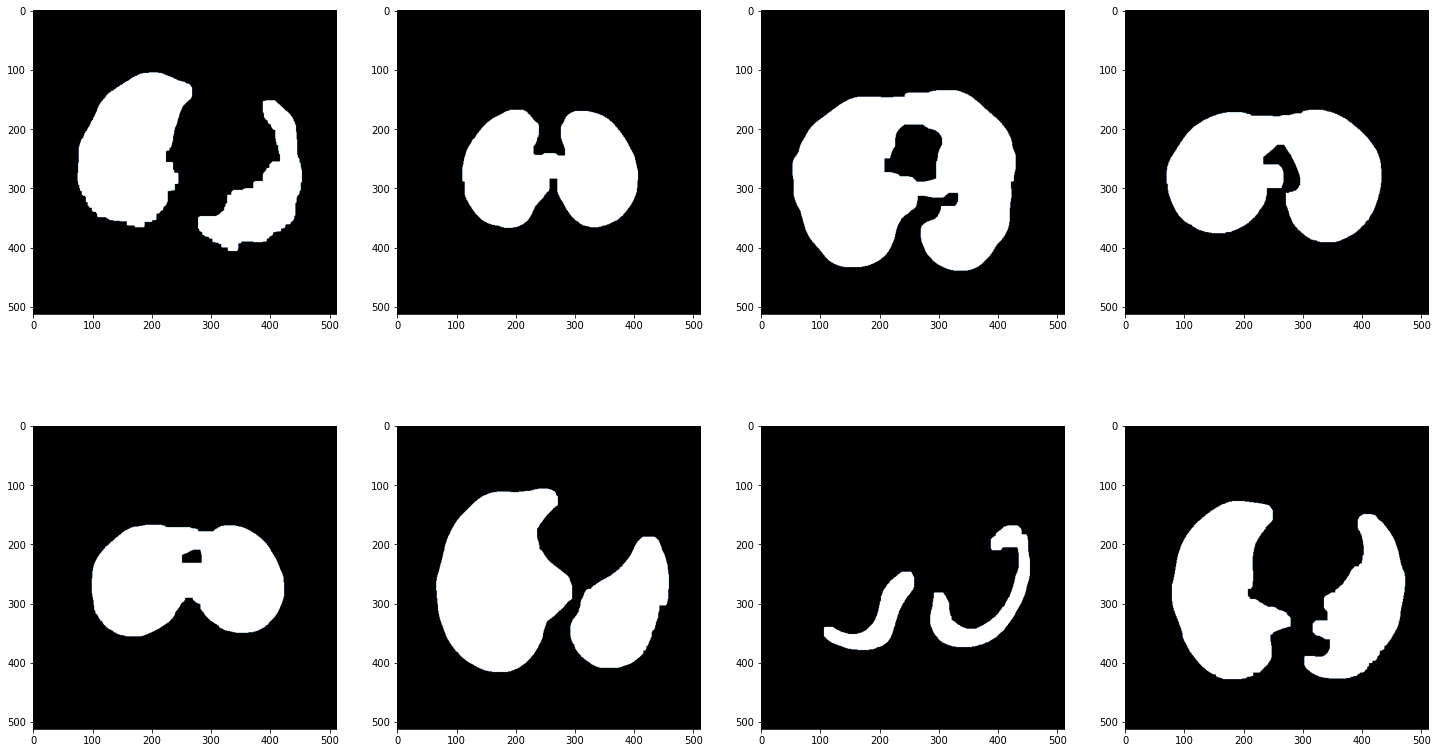

In [17]:
final_masks = []
for img in p_final_masks:
    img = cv2.bitwise_not(img.astype(np.uint8))
    img = cv2.erode(img, kernel=np.ones((7,7)))
    img = cv2.bitwise_not(img)
    img = cv2.dilate(img, kernel=np.ones((12,12)))
    img = cv2.erode(img, kernel=np.ones((12,12)))
    final_masks.append(img)
    
display(final_masks)

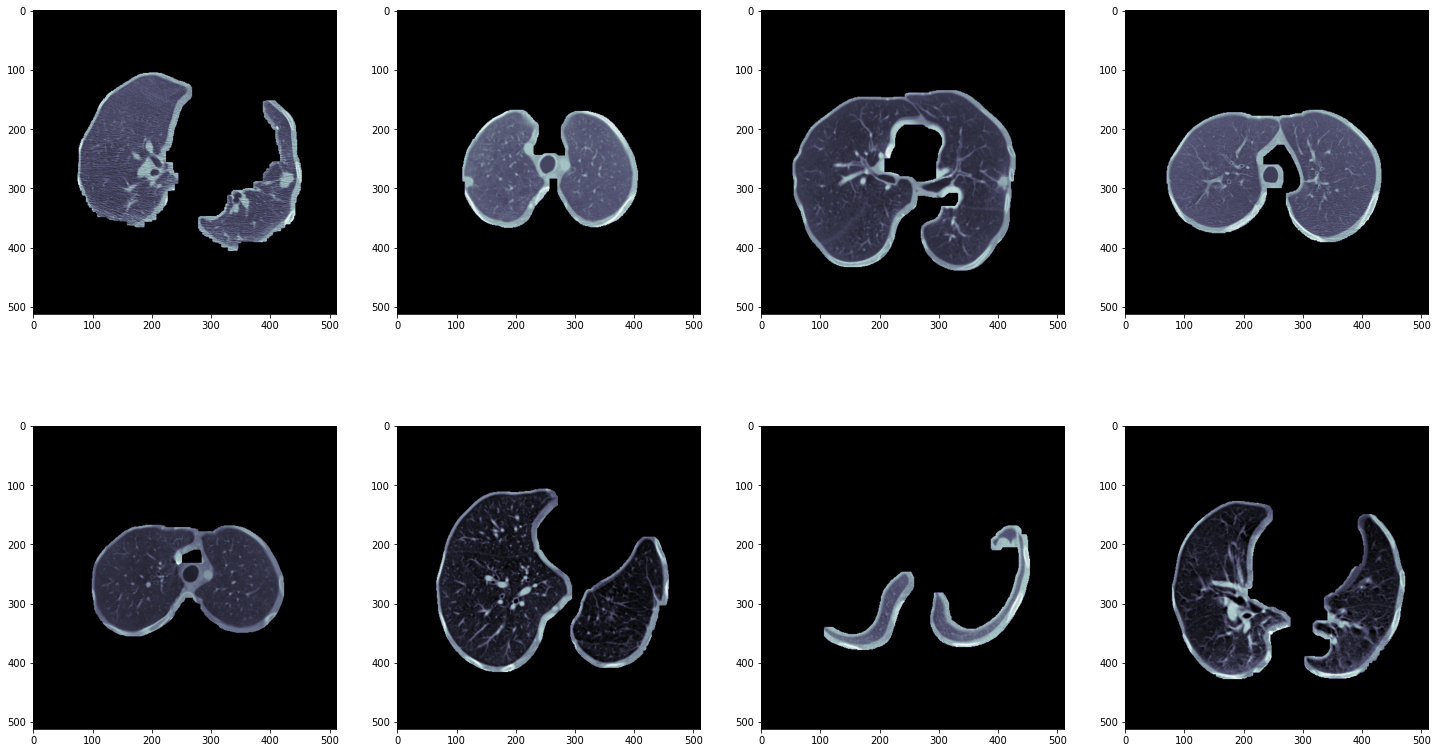

In [18]:
segmented_lungs = []
for i,(img, mask) in enumerate(zip(adjusted_norm_imgs, final_masks)):
    img = img.astype(np.uint8)
    mask = mask.astype(np.uint8)
    seg = cv2.bitwise_and(img[layers[i]], img[layers[i]], mask=mask)
    segmented_lungs.append(seg)

display(segmented_lungs)